#### Import Needed Packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import joblib

#### Load Data

In [ ]:
df = pd.read_csv('/content/yield_df.csv')
df.drop(df.columns[0], axis=1, inplace=True)

In [ ]:
df.head()

,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,Albania,Maize,1990,36613,1485.0,121.0,16.37
1,Albania,Potatoes,1990,66667,1485.0,121.0,16.37
2,Albania,"Rice, paddy",1990,23333,1485.0,121.0,16.37
3,Albania,Sorghum,1990,12500,1485.0,121.0,16.37
4,Albania,Soybeans,1990,7000,1485.0,121.0,16.37


#### Data Visualizations

Dataset Shape: (28242, 7)


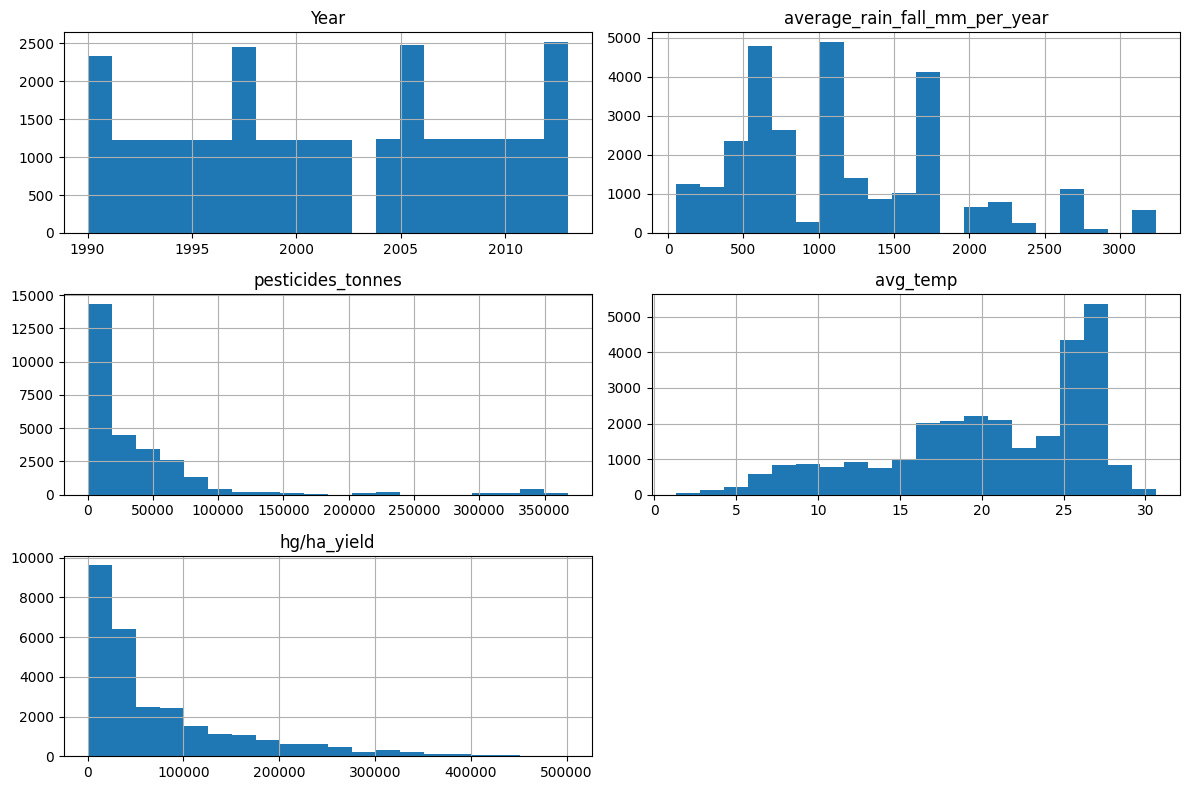

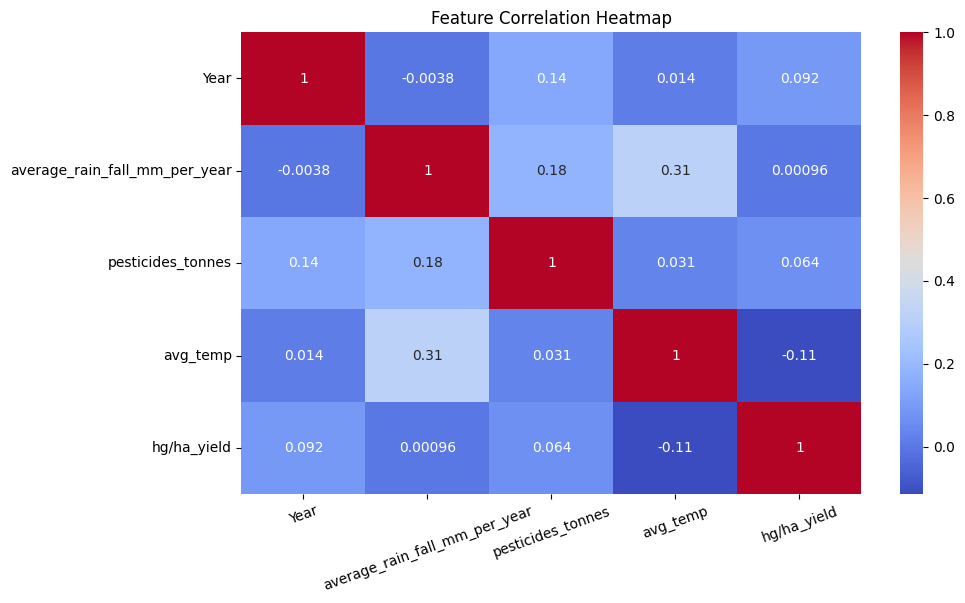

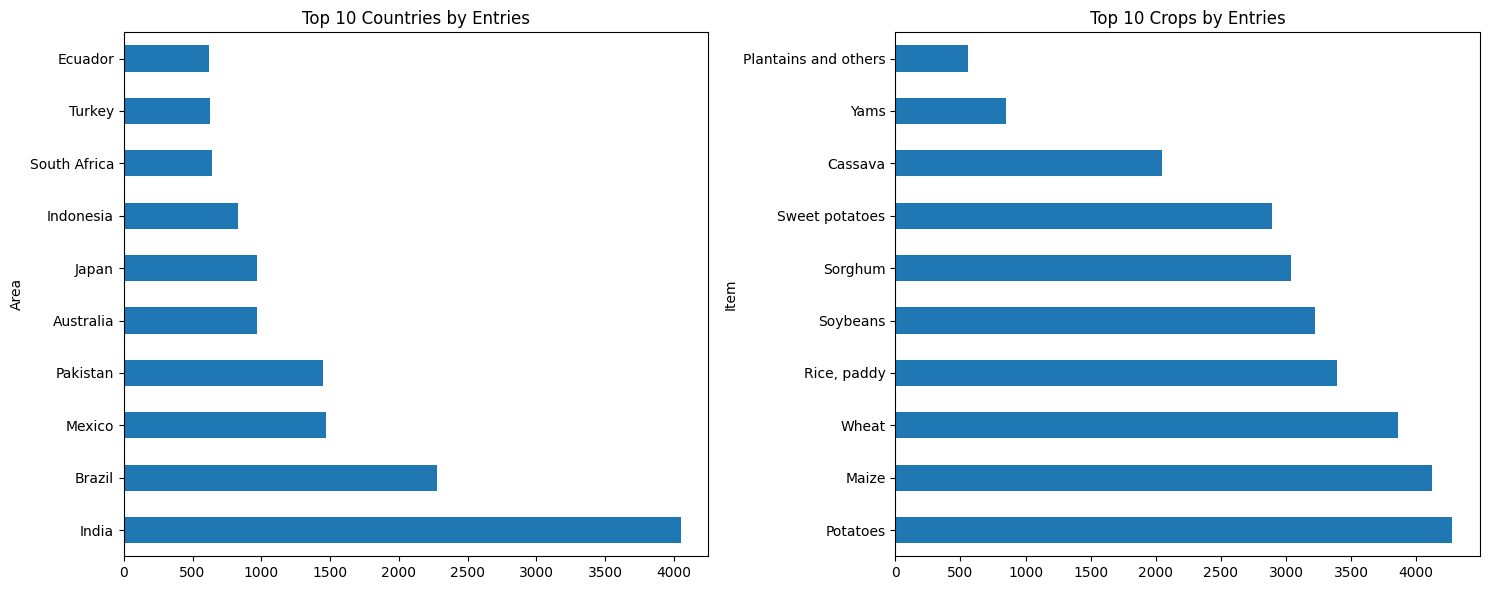

In [ ]:
print(f"Dataset Shape: {df.shape}")

# Numerical features analysis
num_features = ['Year', 'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp']
df[num_features + ['hg/ha_yield']].hist(figsize=(12, 8), bins=20)
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df[num_features + ['hg/ha_yield']].corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.xticks(rotation = 20)
plt.show()

# Categorical features analysis
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
df['Area'].value_counts().head(10).plot(kind='barh', title='Top 10 Countries by Entries')
plt.subplot(1, 2, 2)
df['Item'].value_counts().head(10).plot(kind='barh', title='Top 10 Crops by Entries')
plt.tight_layout()
plt.show()

#### Preprocessing

In [ ]:
X = df.drop('hg/ha_yield', axis=1)
y = df['hg/ha_yield']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [ ]:
cat_features = ['Area', 'Item']

# Column transformations
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

#### Training

In [ ]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'Decision Tree': DecisionTreeRegressor()
}

results = {}
for name, model in models.items():
    model.fit(X_train_processed, y_train)
    y_pred = model.predict(X_test_processed)
    train_pred = model.predict(X_train_processed)

    results[name] = {
        'Train MAE': mean_absolute_error(y_train, train_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
        'Train MSE': mean_squared_error(y_train, train_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'Train R2': r2_score(y_train, train_pred),
        'R2': r2_score(y_test, y_pred)
    }


Model Performance:
                       Train MAE           MAE     Train MSE           MSE  \
Linear Regression  29255.622525  29582.517700  1.756331e+09  1.776121e+09   
Random Forest       1285.552041   3497.676460  1.208432e+07  8.958168e+07   
Decision Tree          0.000000   3755.229598  0.000000e+00  1.512667e+08   

                   Train R2        R2  
Linear Regression  0.756346  0.755142  
Random Forest      0.998324  0.987650  
Decision Tree      1.000000  0.979146  


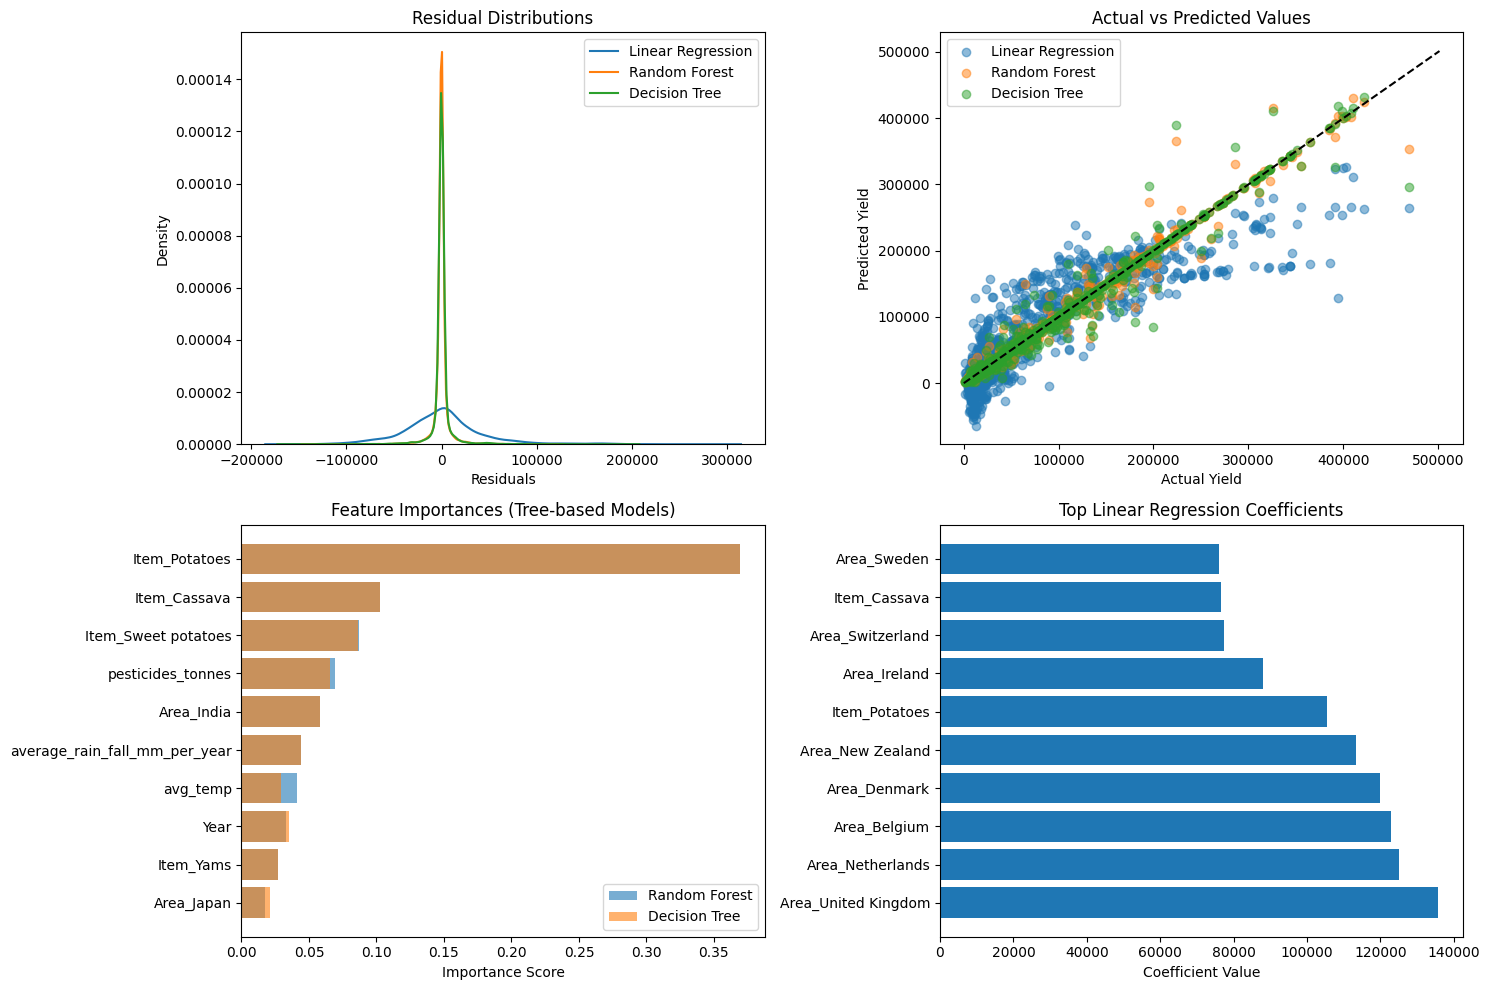

In [ ]:
# Print metrics
metrics_df = pd.DataFrame(results).T
print("\nModel Performance:\n", metrics_df)

plt.figure(figsize=(15, 10))

# 1. Residual Analysis Plot
plt.subplot(2, 2, 1)
for idx, (name, model) in enumerate(models.items()):
    residuals = y_test - model.predict(X_test_processed)
    sns.kdeplot(residuals, label=name)
plt.title('Residual Distributions')
plt.xlabel('Residuals')
plt.legend()

# 2. Actual vs Predicted Plot
plt.subplot(2, 2, 2)
sample_idx = np.random.choice(len(y_test), 1000, replace=False)
for name, model in models.items():
    plt.scatter(y_test.iloc[sample_idx], model.predict(X_test_processed[sample_idx]),
                alpha=0.5, label=name)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Yield')
plt.ylabel('Predicted Yield')
plt.legend()

# 3. Feature Importance (for tree-based models)
plt.subplot(2, 2, 3)
feature_names = num_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out(cat_features))

for idx, (name, model) in enumerate(models.items()):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        top_idx = np.argsort(importances)[-10:]  # Top 10 features
        plt.barh(np.array(feature_names)[top_idx], importances[top_idx],
                 label=name, alpha=0.6)
plt.title('Feature Importances (Tree-based Models)')
plt.xlabel('Importance Score')
plt.legend()

# 4. Coefficient Plot for Linear Regression
plt.subplot(2, 2, 4)
lr_model = models["Linear Regression"]
coefs = pd.DataFrame({
    'feature': feature_names,
    'coef': lr_model.coef_,
    'abs_coef': np.abs(lr_model.coef_)
})
coefs = coefs.sort_values('abs_coef', ascending=False).head(10)

plt.barh(coefs['feature'], coefs['coef'])
plt.title('Top Linear Regression Coefficients')
plt.xlabel('Coefficient Value')
plt.tight_layout()
plt.show()


#### Best Model Selection & Saving

In [ ]:
best_model_name = min(results, key=lambda x: results[x]['MSE'])
best_model = models[best_model_name]
print(f"\nBest Model Identified: {best_model_name}")

# Save best model and preprocessor
joblib.dump(best_model, 'best_model.joblib', compress=4)
joblib.dump(preprocessor, 'preprocessor.joblib')
print("Best model and preprocessor saved successfully!")


Best Model Identified: Random Forest
Best model and preprocessor saved successfully!


#### Linear Regression Scatter Plot

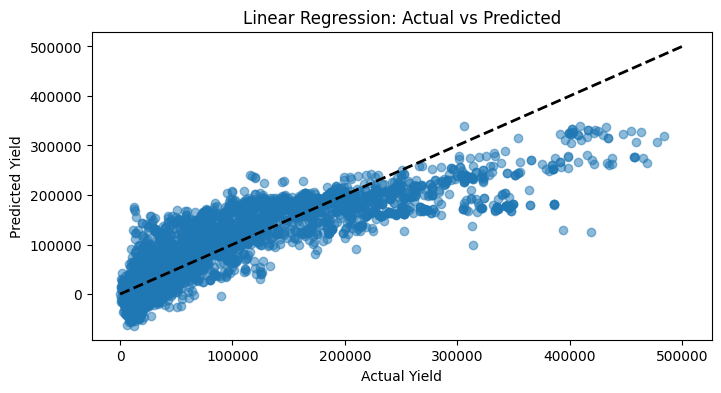

In [ ]:
plt.figure(figsize=(8, 4))
plt.scatter(y_test, models['Linear Regression'].predict(X_test_processed), alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Yield')
plt.ylabel('Predicted Yield')
plt.title('Linear Regression: Actual vs Predicted')
plt.show()

#### Sample Prediction

In [ ]:
def predict_yield(input_data):
    processed_data = preprocessor.transform(pd.DataFrame([input_data]))
    return best_model.predict(processed_data)[0]

In [ ]:
sample_input = X_test.iloc[20]

print(f"\nPredicted Yield: {predict_yield(sample_input):.2f} hg/ha")


Predicted Yield: 36070.00 hg/ha
